# 自动驾驶 - 汽车检测

本节你将学习如何使用非常强大的 YOLO 模型进行目标检测。本节中的许多思想来自两篇 YOLO 论文：Redmon 等人, 2016 (https://arxiv.org/abs/1506.02640) 和 Redmon 与 Farhadi, 2016 (https://arxiv.org/abs/1612.08242)。

**你将学到如何**：
- 在汽车检测数据集上使用目标检测  
- 处理边界框（bounding boxes）



## 1 - 问题描述

你正在开发一辆自动驾驶汽车。作为该项目的关键组成部分，你希望首先构建一个汽车检测系统。为了收集数据，你在汽车前引擎盖上安装了一台摄像头，它会在你驾驶时每隔几秒拍摄前方道路的照片。

<center>
<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> 汽车行驶过程中，从车载摄像头拍摄的照片。<br>特别感谢 [drive.ai](https://www.drive.ai/) 提供的数据集！Drive.ai 是一家为自动驾驶车辆提供“大脑”的公司。
</center></caption>

<img src="nb_images/driveai.png" style="width:100px;height:100;">

你已将这些图片收集到一个文件夹中，并通过在每辆车上绘制边界框进行了标注。下面是一个边界框的示例。

<img src="nb_images/box_label.png" style="width:500px;height:250;">
<caption><center> <u> **图1** </u>: **边界框示例**<br> </center></caption>

如果你希望 YOLO 识别 80 个类别，可以将类别标签 $c$ 表示为 1 到 80 的整数，或者表示为一个 80 维向量（80 个数字），其中一个分量为 1，其余为 0。

在本程序中，你将学习 YOLO 的工作原理，然后将其应用于汽车检测。由于 YOLO 模型训练计算量非常大，你将使用加载预训练权重。


YOLO（"you only look once"）是一种流行的算法，因为它在实现高精度的同时还能实时运行。该算法之所以称为“只看一次”，是因为它只需要对图像进行一次前向传播就能进行预测。经过非极大值抑制（non-max suppression）后，它会输出识别出的对象及其边界框。

## 2 - 模型细节

首先需要了解：
- **输入** 是形状为 (m, 608, 608, 3) 的图像批次
- **输出** 是一个包含边界框及识别类别的列表。每个边界框由 6 个数字表示 $(p_c, b_x, b_y, b_h, b_w, c)$，如上所述。如果将 $c$ 展开成 80 维向量，则每个边界框由 85 个数字表示。

我们将使用 5 个 anchor 框。因此可以将 YOLO 架构理解为：IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85)。

下面详细介绍这个编码表示的内容。

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **图2** </u>: **YOLO 编码架构**<br> </center></caption>

如果一个物体的中心/中点落在某个网格单元内，那么该网格单元负责检测该物体。


由于我们使用了 5 个 anchor 框，因此每个 19 x 19 的网格单元会编码 5 个框的信息。Anchor 框仅由其宽度和高度定义。

为了简化，我们将形状为 (19, 19, 5, 85) 编码的最后两个维度展平。因此，Deep CNN 的输出为 (19, 19, 425)。

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **图3** </u>: **展平最后两个维度**<br> </center></caption>


现在，对于每个框（每个网格单元中的每个框），我们将计算以下元素级乘积，并提取该框包含某个类别的概率。

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u> **图4** </u>: **找出每个框检测到的类别**<br> </center></caption>

这是一种可视化 YOLO 在图像上预测的方法：
- 对于每个 19x19 的网格单元，找到概率分数的最大值（在 5 个 anchor 框和不同类别之间取最大值）。
- 根据该网格单元认为最可能的对象为该单元上色。

得到的结果如下图：

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> **图5** </u>: 每个 19x19 网格单元根据其预测概率最大的类别着色。<br> </center></caption>

注意，这种可视化并不是 YOLO 算法本身用于预测的核心部分；它只是可视化算法中间结果的一种方式。


另一种可视化 YOLO 输出的方法是绘制它输出的边界框（bounding boxes）。结果如下图所示：  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **图6** </u>: 每个网格单元提供 5 个框。总计，模型仅通过一次看图（一次前向传播）就预测了 19x19x5 = 1805 个框！不同颜色表示不同类别。<br> </center></caption>

在上图中，我们只绘制了模型分配高概率的框，但这仍然太多。你希望将算法的输出过滤为更少的检测对象。为此，你将使用非极大值抑制（Non-Max Suppression）。具体步骤如下：
- 去掉低分数的框（即模型对该框检测某个类别信心不足）
- 当多个框重叠并检测到相同对象时，只选择一个框。


## 3 - YOLO（PyTorch实现）

在本程序中，我们将使用基于PyTorch的YOLOv5模型实现汽车检测。与TensorFlow/Keras实现相比，PyTorch版本具有以下优势：
- **更简洁的API**：PyTorch的接口更加直观易懂
- **更好的社区支持**：PyTorch是当前深度学习研究的主流框架
- **更易于部署**：支持多种部署方式（ONNX、TensorRT等）


### YOLOv5 与 YOLOv2 对比

| 特性               | YOLOv2                                   | YOLOv5                                  |
|-------------------|----------------------------------------|----------------------------------------|
| 发布年份           | 2017                                   | 2020                                   |
| 框架               | Darknet                                 | PyTorch                                |
| 模型结构           | Darknet-19 主干网络                     | CSPDarknet53 或其他轻量化主干网络       |
| 检测精度           | mAP 中等，性能较 YOLOv1 提升明显       | 高精度，mAP 高，尤其在小目标检测上优秀 |
| 推理速度           | 快，但不如 YOLOv5 灵活                   | 非常快，支持 GPU、ONNX、TensorRT 等加速 |
| 输入尺寸           | 固定 416x416                             | 灵活，可自定义输入尺寸                 |
| 数据增强           | 基本的翻转、缩放                         | Mosaic、MixUp 等先进数据增强方法       |
| 训练方式           | 传统训练，较少预训练权重                | 支持迁移学习和多种预训练权重          |
| 部署方便性         | 需要 Darknet 环境                       | PyTorch 原生，易于导出为 ONNX / TorchScript |
| 小目标检测能力     | 中等                                     | 优秀                                   |
| 社区与生态         | 社区活跃，但已被 YOLOv3/YOLOv4/YOLOv5 超越 | 社区活跃，文档齐全，生态完善LOv5模型的实现和预训练权重


### 3.1 - 导入必要的Python库

首先，我们需要导入本次练习所需的所有Python包：
- **torch**: PyTorch深度学习框架的核心库
- **numpy**: 用于数值计算和数组操作
- **PIL (Pillow)**: 用于图像读取、处理和绘制边界框
- **matplotlib**: 用于图像可视化
- **ultralytics**: 提供YOLOv5模型的实现和预训练权重

In [1]:
# ==========================
# 导入所需的库
# ==========================

import os   # 操作系统接口模块，用于文件和目录操作
import numpy as np   # 科学计算库，支持多维数组与矩阵运算
import torch   # PyTorch 深度学习框架
import torch.nn as nn   # PyTorch 的神经网络模块，提供各种神经网络层
import torch.nn.functional as F   # 提供神经网络常用的函数式接口（如激活函数、卷积等）
from PIL import Image, ImageDraw, ImageFont   # Python 图像处理库PIL，用于图像读取、绘制、文字渲染等
import matplotlib.pyplot as plt   # Matplotlib 绘图库，用于数据可视化
from matplotlib.pyplot import imshow   # 从 pyplot 中单独导入 imshow，用于显示图像
import cv2   # OpenCV 图像处理与计算机视觉库
import random   # Python 随机数模块
from ultralytics import YOLO  # 从 ultralytics 库中导入 YOLO 类（YOLOv5/YOLOv8 都在此库中实现）
# ==========================
# 设置随机种子（保证结果可复现）
# ==========================
torch.manual_seed(42)   # 为 PyTorch 设置随机种子，42 是固定值，可更换
np.random.seed(42)      # 为 NumPy 设置随机种子
random.seed(42)         # 为 Python 内置 random 设置随机种子

# ==========================
# 检查 CUDA 是否可用，并选择设备
# ==========================
# torch.cuda.is_available() : 检查当前环境是否支持 GPU（CUDA）
# torch.device() : 指定使用的计算设备（'cuda' 或 'cpu'）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")   # 打印最终使用的设备

# ==========================
# 设置 Jupyter Notebook 内联绘图模式
# ==========================
# %matplotlib inline : Jupyter 的魔法命令，用于将 matplotlib 图像直接显示在 Notebook 中
%matplotlib inline


使用设备: cpu


### 3.2 - YOLO辅助工具函数


工具函数包括：
- **read_classes()**: 从文件中读取类别名称（如person、car、bus等80个COCO数据集类别）
- **read_anchors()**: 读取锚框（anchor boxes）的尺寸配置
- **generate_colors()**: 为每个类别生成唯一的随机颜色，用于可视化
- **draw_boxes()**: 在图像上绘制检测到的边界框和类别标签

**注意**：这些函数与框架无关，在PyTorch和TensorFlow版本中都可以使用。


In [2]:
# ==========================
# 工具函数定义
# ==========================

def read_classes(classes_path):
    """
    读取类别文件（class names），用于目标检测模型识别类别名称
    
    参数：
        classes_path : str
            类别文件路径，例如 'classes.txt'
            文件内容格式：每行一个类别名称，例如：
                person
                bicycle
                car
                ...
    
    返回：
        class_names : list[str]
            类别名称列表，每个元素为一个类别字符串
            例如 ['person', 'bicycle', 'car', ...]
    """
    # 打开类别文件，使用 utf-8 编码，防止中文或特殊字符乱码
    with open(classes_path, 'r', encoding='utf-8') as f:
        class_names = f.readlines()  # 按行读取所有类别名，每行是字符串，末尾可能带换行符
    
    # 去掉每行字符串的首尾空白字符，包括换行符
    class_names = [c.strip() for c in class_names]
    
    # 返回类别列表
    return class_names


def read_anchors(anchors_path):
    """
    读取锚框（Anchor boxes）文件
    
    锚框是目标检测模型（如 YOLO）用于先验预测的框，
    模型会在这些基础框的中心位置进行偏移预测，输出最终检测框。
    
    参数：
        anchors_path : str
            锚框文件路径，例如 'anchors.txt'
            文件内容一般为一行逗号分隔的浮点数：
                10,13, 16,30, 33,23, ...
            每两个数字表示一个锚框的宽度和高度
    
    返回：
        anchors : np.ndarray, shape=(N, 2)
            numpy 数组，每行表示一个锚框的宽度和高度 [w, h]
            例如：
                [[10, 13],
                 [16, 30],
                 [33, 23],
                 ...]
    """
    import numpy as np
    
    # 打开锚框文件，读取第一行内容
    with open(anchors_path, 'r') as f:
        anchors_line = f.readline()
    
    # 按逗号分割字符串并转换为浮点数列表
    anchors = [float(x) for x in anchors_line.split(',')]
    
    # 将一维列表转换为 N x 2 的二维 numpy 数组，每两列表示一个锚框的宽高
    anchors = np.array(anchors).reshape(-1, 2)
    
    # 返回锚框数组
    return anchors


def generate_colors(class_names):
    """
    为每个类别生成固定的随机颜色（RGB 三元组），用于绘制检测框
    
    参数：
        class_names : list[str]
            类别名称列表，例如 ['person', 'bicycle', 'car', ...]
    
    返回：
        colors : dict
            颜色字典，键为类别名称，值为 RGB 元组 (R, G, B)
            例如 {'person': (12, 200, 50), 'bicycle': (255, 100, 30), ...}
    """
    import random
    # 设置随机种子，保证每次生成颜色一致
    random.seed(42)
    
    colors = {}
    for class_name in class_names:
        # 随机生成 0~255 的三个整数作为 R、G、B 分量
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        colors[class_name] = (r, g, b)
    
    return colors


def draw_boxes(image, scores, boxes, classes, class_names, colors):
    """
    在图像上绘制检测框和类别标签
    
    参数：
        image : PIL.Image.Image
            PIL 图像对象，绘制在该图像上
        scores : list[float] 或 np.ndarray
            每个检测框的置信度分数，范围 [0, 1]
            与 boxes 和 classes 一一对应
        boxes : list[list[float]] 或 np.ndarray
            检测框坐标列表，每个框格式为 [y1, x1, y2, x2]
            y1：框上边界，x1：左边界，y2：下边界，x2：右边界
        classes : list[int] 或 np.ndarray
            类别索引列表，对应 class_names 的索引
        class_names : list[str]
            类别名称列表，例如 ['person', 'bicycle', 'car', ...]
        colors : dict
            颜色字典，键为类别名称，值为 RGB 元组，例如 {'person': (12, 200, 50), ...}
    
    功能：
        - 在每个检测框位置绘制矩形框
        - 在框上方绘制类别和置信度文本标签
        - 打印每个检测框的类别、分数及坐标信息到控制台
    """

    
    # 创建绘图对象，用于在 image 上绘制
    draw = ImageDraw.Draw(image)
    
    # 尝试加载指定字体
    try:
        font = ImageFont.truetype("arial.ttf", 15)  # 使用 arial.ttf 字体，字号 15
    except:
        font = ImageFont.load_default()  # 加载默认字体
    
    # 遍历每个检测框
    for i, box in enumerate(boxes):
        # 获取类别名称
        class_idx = int(classes[i])
        class_name = class_names[class_idx]
        color = colors[class_name]  # 获取对应颜色
        score = float(scores[i])    # 获取置信度
        
        # 获取边界框坐标，并取整
        top, left, bottom, right = box
        top = max(0, int(top))
        left = max(0, int(left))
        bottom = min(image.size[1], int(bottom))  # image.size[1] 是高度
        right = min(image.size[0], int(right))   # image.size[0] 是宽度
        
        # 绘制矩形框（两层矩形加粗）
        for j in range(2):
            draw.rectangle(
                [left + j, top + j, right - j, bottom - j],
                outline=color
            )
        
        # 构建文本标签
        label = f"{class_name} {score:.2f}"
        
        # 获取文本尺寸
        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        # 计算文字位置（优先放在框上方）
        if top - text_height >= 0:
            text_origin = (left, top - text_height)
        else:
            text_origin = (left, top + 1)
        
        # 绘制文字背景矩形
        draw.rectangle(
            [text_origin[0], text_origin[1], text_origin[0] + text_width, text_origin[1] + text_height],
            fill=color
        )
        
        # 绘制文字
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        
        # 打印检测信息
        print(f"{class_name} {score:.2f} ({left}, {top}) -> ({right}, {bottom})")
    
    # 删除绘图对象，释放资源
    del draw


print("工具函数定义完成！")


工具函数定义完成！


### 3.3 - YOLO核心算法实现

现在我们将实现YOLO算法的核心组件。这些组件在PyTorch和TensorFlow版本中的原理是相同的，但实现方式有所不同。

#### 3.3.1 - 交并比(IoU)计算

**交并比（Intersection over Union, IoU）** 是目标检测中最重要的评估指标之一。

<img src="nb_images/iou.png" style="width:500px;height:400;">

**IoU的作用**：
1. **衡量预测框的准确性**：IoU值越接近1，说明预测框与真实框越接近
2. **非极大值抑制（NMS）的核心**：通过IoU判断两个框是否检测的是同一个物体
3. **训练时的损失计算**：IoU也用于计算定位损失

**实现细节**：
- 使用两个角的坐标(x1, y1, x2, y2)表示边界框
- 计算两个框的交集面积和并集面积
- IoU = 交集面积 / 并集面积

**PyTorch实现说明**：虽然这个函数使用numpy实现（与框架无关），但在实际的YOLOv5中，所有计算都在PyTorch的tensor上进行，可以利用GPU加速。


In [3]:
def iou(box1, box2):
    """
    实现两个锚框的交并比（IoU, Intersection over Union）的计算
    
    参数：
        box1 : tuple
            第一个锚框，格式为 (x1, y1, x2, y2)，
            其中 (x1, y1) 表示左上角坐标，(x2, y2) 表示右下角坐标
        box2 : tuple
            第二个锚框，格式同上
    
    返回：
        iou : float
            两个框的交并比，范围在 [0, 1]
    """
    # ==========================
    # 1. 计算相交区域坐标
    # ==========================
    
    # xi1 表示相交区域左上角的水平坐标（x）
    # 取两个框左边界的最大值（靠右的边界）
    # 解释：
    #   box1[0] 是框1的左边界 x1
    #   box2[0] 是框2的左边界 x1
    #   相交区域的左边界要取两个左边界中靠右的那个
    xi1 = max(box1[0], box2[0])   
    
    # yi1 表示相交区域左上角的垂直坐标（y）
    # 取两个框上边界的最大值（靠下的边界）
    # 解释：
    #   box1[1] 是框1的上边界 y1
    #   box2[1] 是框2的上边界 y1
    #   相交区域的上边界要取两个上边界中靠下的那个
    yi1 = max(box1[1], box2[1])   
    
    # xi2 表示相交区域右下角的水平坐标（x）
    # 取两个框右边界的最小值（靠左的边界）
    # 解释：
    #   box1[2] 是框1的右边界 x2
    #   box2[2] 是框2的右边界 x2
    #   相交区域的右边界要取两个右边界中靠左的那个
    xi2 = min(box1[2], box2[2])   
    
    # yi2 表示相交区域右下角的垂直坐标（y）
    # 取两个框下边界的最小值（靠上的边界）
    # 解释：
    #   box1[3] 是框1的下边界 y2
    #   box2[3] 是框2的下边界 y2
    #   相交区域的下边界要取两个下边界中靠上的那个
    yi2 = min(box1[3], box2[3])   

    
    # ==========================
    # 2. 计算相交区域面积
    # ==========================
    
    # 计算两个框在水平方向上的重叠宽度
    # xi2 - xi1 表示右边界最小值减去左边界最大值
    # 如果两个框没有重叠，xi2 - xi1 会小于 0，因此使用 max(0, ...) 保证宽度非负
    inter_width = max(0, xi2 - xi1)    
    # 解释：
    # xi1 = max(box1[0], box2[0])   # 左边界取两个框中靠右的那个
    # xi2 = min(box1[2], box2[2])   # 右边界取两个框中靠左的那个
    # 所以 xi2 - xi1 就是水平相交长度
    # 若 xi2 < xi1，说明两框不重叠，此时相交宽度为 0
    
    # 计算两个框在垂直方向上的重叠高度
    # yi2 - yi1 表示下边界最小值减去上边界最大值
    # 同样使用 max(0, ...) 保证高度非负
    inter_height = max(0, yi2 - yi1)   
    # 解释：
    # yi1 = max(box1[1], box2[1])   # 上边界取两个框中靠下的那个
    # yi2 = min(box1[3], box2[3])   # 下边界取两个框中靠上的那个
    # 所以 yi2 - yi1 就是垂直相交长度
    # 若 yi2 < yi1，说明两框在垂直方向不重叠，相交高度为 0
    
    # inter_area 已在上一步计算得到
    # 公式：inter_area = inter_width * inter_height
    # 解释：
    #   inter_width 代表相交区域的宽度
    #   inter_height 代表相交区域的高度
    #   如果两个框没有重叠，则 inter_width 或 inter_height 为 0
    #   所以 inter_area = inter_width * inter_height 保证面积非负
    #   该值用于 IoU 公式的分子
    inter_area = inter_width * inter_height   
    
    # ==========================
    # 3. 计算两个框的面积
    # ==========================
    # 第一个框的面积
    # box1[2] 是框右下角的 x 坐标 (x2)
    # box1[0] 是框左上角的 x 坐标 (x1)
    # box1[3] 是框右下角的 y 坐标 (y2)
    # box1[1] 是框左上角的 y 坐标 (y1)
    # 面积 = 宽度 * 高度
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])   
    
    # 第二个框的面积，计算方法同上
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])   
    
    # ==========================
    # 4. 计算并集面积
    # ==========================
    # 并集面积公式：
    # union_area = box1_area + box2_area - inter_area
    # 解释：
    #   union_area 表示两个框覆盖的总面积
    #   box1_area + box2_area 会重复计算相交区域
    #   因此需要减去 inter_area
    union_area = box1_area + box2_area - inter_area   
    
    # ==========================
    # 5. 计算交并比 IoU
    # ==========================
    # IoU = 相交面积 / 并集面积
    # 如果并集面积为 0（框不存在或异常），返回 0 避免除零错误
    iou = inter_area / union_area if union_area > 0 else 0
    # 解释：
    #   iou 值范围 [0, 1]
    #   iou = 0 表示两个框完全不重叠
    #   iou = 1 表示两个框完全重合
    #   iou 在目标检测中用于衡量预测框与真实框的重叠程度
    
    return iou


In [4]:
# ==========================
# 测试 IoU 函数
# ==========================
print("===== 测试 IoU 函数 =====")
box1 = (2, 1, 4, 3)   # 第一个框的坐标
box2 = (1, 2, 3, 4)   # 第二个框的坐标
print(f"iou = {iou(box1, box2)}")   # 打印计算结果


===== 测试 IoU 函数 =====
iou = 0.14285714285714285


#### 3.3.2 - 非极大值抑制(NMS)

即使在对类别分数进行阈值过滤后，YOLO仍然可能为同一个物体预测多个重叠的边界框。为了解决这个问题，我们需要使用**非极大值抑制（Non-Maximum Suppression, NMS）**。

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **图 7** </u>: 在这个例子中，模型预测了 3 辆车，但实际上这只是对同一辆车的 3 个预测。运行非极大值抑制（NMS）会从这 3 个框中只选择最准确（概率最高）的一个。 <br> </center></caption>

**NMS算法原理**：
1. **按置信度排序**：将所有检测框按照置信度分数从高到低排序
2. **选择最优框**：选择置信度最高的框作为最终检测结果
3. **计算IoU**：计算该框与所有剩余框的IoU
4. **删除重叠框**：删除IoU大于阈值（如0.5）的框（这些框很可能检测的是同一个物体）
5. **重复迭代**：对剩余的框重复步骤2-4，直到处理完所有框

**PyTorch vs TensorFlow实现的区别**：
- **TensorFlow/Keras版本**：使用`tf.image.non_max_suppression()`和`K.gather()`函数
- **PyTorch版本**：使用numpy实现，但YOLOv5内部使用`torchvision.ops.nms()`实现GPU加速的NMS
- **优势**：PyTorch的实现通常更快，尤其在GPU上

**实现细节**：
- 为每个类别分别执行NMS（避免不同类别的物体互相干扰）
- 可以设置最大检测框数量（max_boxes）限制输出
- IoU阈值通常设置为0.45-0.5


**NMS可视化示例**：

下图展示了NMS的工作过程。初始时模型可能对同一辆车预测了多个边界框，NMS通过IoU计算识别出这些重叠的框，只保留置信度最高的那个。


In [5]:
def nms_boxes(boxes, scores, iou_threshold=0.5):
    """
    非极大值抑制（Non-Maximum Suppression, NMS）
    主要作用：在多个候选框中，去掉重复度高（IoU较大）的框，只保留分数最高的框
    
    参数：
        boxes : np.ndarray
            形状 (N, 4)，每一行表示一个边界框 [x1, y1, x2, y2]
            - x1, y1 表示左上角坐标
            - x2, y2 表示右下角坐标
        scores : np.ndarray
            形状 (N, )，对应每个框的置信度分数
        iou_threshold : float, 默认=0.5
            - 用于判断两个框是否“太重叠”
            - 若 IoU > 阈值，则删除分数较低的框
    
    返回:
        keep : list[int]
            保留下来的框的索引列表（相对于输入的 boxes）
    """
    
    # ==========================
    # 步骤0：检查输入
    # len(boxes) 返回预测框的数量
    # 如果没有输入框，直接返回空列表，避免后续报错
    # ==========================
    if len(boxes) == 0:
        return []

    # ==========================
    # 步骤1：按置信度分数从大到小排序
    # ==========================
    # scores.argsort() 返回从小到大排序后的索引数组
    # [::-1] 将索引数组倒序，实现从大到小排序
    # order 中存储了按分数从高到低的预测框索引
    order = scores.argsort()[::-1]

    # ==========================
    # 初始化保留列表
    # keep 用于存储最终保留下来的预测框索引
    # ==========================
    keep = []

    # ==========================
    # 循环处理每个预测框
    # order.size 表示当前剩余框的数量
    # 只要还有框未处理，就继续循环
    # ==========================
    while order.size > 0:
        
        # ==========================
        # 步骤2：选择当前分数最高的框
        # ==========================
        i = order[0]        # 取分数最高的框索引
        keep.append(i)      # 将该框加入保留列表

        # ==========================
        # 特殊情况处理：
        # 如果当前只剩下一个框，处理完毕后直接退出循环
        # 避免后续对空数组进行索引报错
        # ==========================
        if order.size == 1:
            break

        # ==========================
        # 步骤3：计算 IoU（Intersection over Union）
        # ==========================
        # 计算当前最高分框 i 与剩余所有框 j 的 IoU
        # order[1:] 表示剩余框的索引（不包括当前最高分框）
        # iou(boxes[i], boxes[j]) 为自定义函数，计算两个框的交并比
        # np.array([...]) 将列表转换为 ndarray，方便后续索引操作
        ious = np.array([iou(boxes[i], boxes[j]) for j in order[1:]])

        # ==========================
        # 步骤4：根据 IoU 阈值筛选框
        # ==========================
        # np.where(ious <= iou_threshold)[0] 返回 IoU 小于等于阈值的索引
        # 也就是说，这些框与当前最高分框重叠较小，可以保留
        inds = np.where(ious <= iou_threshold)[0]

        # ==========================
        # 更新 order，仅保留 IoU 较小的框继续处理
        # 注意：
        #   order[0] 是当前最高分框，已经加入 keep
        #   order[1:] 是剩余框
        #   inds + 1 对应原始 order 中的索引
        # ==========================
        order = order[inds + 1]

    # ==========================
    # 返回最终保留下来的框的索引列表
    # 可以通过 boxes[keep] 获取对应的预测框
    # ==========================
    return keep


In [6]:
# =====================================
# 过滤检测框函数
# =====================================
#
# 注意（前置说明）：
# 1) 本函数假设输入参数都是 numpy.ndarray（或能被 numpy 索引的同形结构）。
#    - boxes: (N, 4) 数组或矩阵，坐标格式必须为 [x1, y1, x2, y2]（左上角 (x1,y1)，右下角 (x2,y2)）
#      * 推荐 dtype：np.float32 或 np.float64（浮点更通用）
#      * 要求 x2 >= x1, y2 >= y1（否则 IoU 计算或可视化会异常）
#    - scores: (N, ) 一维数组，表示每个框的置信度分数，float 类型
#    - classes: (N, ) 一维数组，类别索引，推荐整数类型（如 np.int32 或 np.int64）
#
# 2) 返回值类型与形状：
#    - filtered_boxes: (M, 4) ndarray（M 为保留下来的框数量）
#    - filtered_scores: (M, ) ndarray
#    - filtered_classes: (M, ) ndarray
#    * 注：原始版本中遇到“无框时”返回 np.array([])，这会导致 boxes 返回形状为 (0,) —— 不利于后续直接索引。
#      更好的做法是返回 shapes (0,4), (0,), (0,)。下面注释会建议如何改进返回空结果以保持形状一致。
#
# 3) nms_boxes 函数假设（必须保证）：
#    - 签名：nms_boxes(cls_boxes, cls_scores, iou_threshold)
#    - 输入：cls_boxes 形状 (M,4)，cls_scores 形状 (M,)
#    - 输出：一个一维整型索引数组或列表（相对于 cls_boxes 的索引），例如：[0, 2, 5]
#    - 返回的索引顺序建议为任意，但通常按保留框分数从高到低更直观。
#
# 4) 性能提示：
#    - NMS 在单类上通常为 O(m^2)（m = 该类框数），当某类框很多时会较慢。
#    - 若性能敏感，可在调用 NMS 前先按 score 截断（例如只保 top-k），或将 IoU 计算向量化、使用更快速的 C++/CUDA 实现。
#
# 5) 稳定性 & 精度：
#    - 当 classes 包含浮点数（而非整数）时，np.unique 和相等比较可能受浮点精度影响（尽量使用整数类别）。
#    - 当 scores 包含 NaN 时，比较 (scores >= score_threshold) 会得到 False（即会被过滤掉），可根据需要先处理 NaN。
#
# =====================================

def filter_boxes(boxes, scores, classes,
                 score_threshold=0.25,
                 iou_threshold=0.45,
                 max_boxes=100):
    """
    过滤检测框的主函数
    
    参数说明（类型与形状）：
        boxes: np.ndarray, shape (N, 4)
            每一行为 [x1, y1, x2, y2]，坐标基于相同图像尺度
        scores: np.ndarray, shape (N,)
            每个框对应的置信度分数，float 类型
        classes: np.ndarray, shape (N,)
            每个框对应的类别索引（整数类型最佳）
        score_threshold: float
            小于该分数的框会被丢弃（先验过滤）
        iou_threshold: float
            传递给 NMS 的 IoU 阈值，用于抑制重叠框
        max_boxes: int
            最多保留的框数量，若最终框多于该数，则只取分数最高的前 max_boxes 个
    
    返回：
        keep_boxes: np.ndarray, shape (M,4)
        keep_scores: np.ndarray, shape (M,)
        keep_classes: np.ndarray, shape (M,)
        —— 若 M==0，推荐返回 shapes (0,4), (0,), (0,)（便于 downstream 无需额外 shape 判断）
    """

    # --------------------------
    # 步骤1：按分数阈值做初筛（非常重要，用于剪掉明显低分预测，减少后续 NMS 计算量）
    # --------------------------
    # mask 的计算：
    #   scores >= score_threshold 会对 scores 数组逐元素比较，返回布尔数组（shape (N,)）
    #   注意：如果 scores 中含 NaN，则 NaN >= threshold 为 False —— 该框会被丢弃
    mask = scores >= score_threshold
    # 下面三行使用布尔索引把 boxes, scores, classes 同步过滤
    # 重要：布尔索引（advanced indexing）会返回原数组的 **拷贝(copy)**，不是 view。
    #   这意味着对 boxes = boxes[mask] 的修改不会影响输入参数 boxes（函数内为局部变量）
    boxes = boxes[mask]
    scores = scores[mask]
    classes = classes[mask]

    # 说明：len(boxes) 返回 boxes 在第 0 轴上的长度（即剩余框数）；当 boxes 形状为 (0,4) 时，len 为 0
    if len(boxes) == 0:
        return np.zeros((0, 4), dtype=boxes.dtype), np.zeros((0,), dtype=scores.dtype), np.zeros((0,), dtype=classes.dtype)
        # 注释建议：在实际项目中，优先使用上述返回，能避免 downstream 报错。
       # return np.array([]), np.array([]), np.array([])

    # --------------------------
    # 步骤2：按类别分别进行 NMS（通常需要按类别做，因为不同类别的重叠不应相互抑制）
    # --------------------------
    # np.unique(classes) 返回去重并排序后的类别值（注意：结果是排序好的）
    # 返回类型通常为 np.ndarray，例如 array([0,1,2])
    unique_classes = np.unique(classes)

    # 这三个列表用于暂存各类别的 NMS 结果（先 collect，再合并）
    # 每个元素都是 ndarray（可能有空 ndarray）
    keep_boxes = []    # 列表中的每个元素：shape (K_i, 4)
    keep_scores = []   # 列表中的每个元素：shape (K_i,)
    keep_classes = []  # 列表中的每个元素：shape (K_i,)

    # 遍历每个类别，单独处理
    for cls in unique_classes:
        # cls_mask 为布尔数组，标记当前类别的框
        # 注意：当 classes 的 dtype 为浮点数时，相等比较可能因精度问题导致意外结果（故推荐整型类别）
        cls_mask = classes == cls

        # 使用布尔索引取出属于当前类别的 boxes 和 scores
        # 这两行都会返回拷贝（advanced indexing）
        cls_boxes = boxes[cls_mask]     # shape (M_cls, 4)
        cls_scores = scores[cls_mask]   # shape (M_cls,)

        # 小的保护：如果当前类别没有框（理论上不会，因为 unique_classes 来源于 classes，但以防万一）
        if len(cls_boxes) == 0:
            # 跳过该类别（不 append 空数组也可以，但稍后 concat 时需要注意）
            continue

        # --------------------------
        # 在这里调用 NMS（用户需保证 nms_boxes 已定义并行为正确）
        # --------------------------
        # 假设 nms_boxes 返回的是相对于 cls_boxes 的索引数组（例如 [0,2,5]）
        # 强烈建议 nms_boxes 返回 np.ndarray（dtype=int），以便后面直接索引使用。
        keep_idx = nms_boxes(cls_boxes, cls_scores, iou_threshold)

        # 输入校验：
        #   - 当 nms_boxes 返回空列表/数组时，keep_idx 可能是 [] 或 np.array([])
        #   - 为了防止后续索引报错，最好将其转换为整型 ndarray
        if isinstance(keep_idx, list):
            # 将 python 列表转为 numpy array（整型索引）
            keep_idx = np.array(keep_idx, dtype=np.int64)
        elif isinstance(keep_idx, np.ndarray):
            # 确保为整型索引（若为 bool 或 float 则强制转换）
            keep_idx = keep_idx.astype(np.int64, copy=False)
        else:
            # 若返回其他类型（极不规范），尝试转换
            keep_idx = np.array(keep_idx, dtype=np.int64)

        # ========== 根据 keep_idx 选出保留下来的框、分数，并生成类别数组 ==========
        # cls_boxes[keep_idx]：按 keep_idx 顺序取出对应框（返回拷贝）
        # 当 keep_idx 为空时，结果为形状 (0,4) 的空数组（注意 dtype 保持 cls_boxes 的 dtype）
        keep_boxes.append(cls_boxes[keep_idx])         # shape (K_keep, 4) 或 (0,4)
        keep_scores.append(cls_scores[keep_idx])       # shape (K_keep,) 或 (0,)
        # np.full(len(keep_idx), cls) 生成与保留框数量相同的类别标签数组
        # 若 cls 是 numpy 标量（如 np.int64(2)），np.full 会保留相应 dtype（通常为 int）
        keep_classes.append(np.full(len(keep_idx), cls))

    # ===== 注意一个微妙点=====
    # keep_boxes 是一个列表：
    #   - 当 unique_classes 为空时（即 classes 原本为空），keep_boxes 为空列表 → len(keep_boxes)==0
    #   - 当 unique_classes 不为空，但某些类别的 keep_idx 全为空（即 append 了空数组），则 keep_boxes 列表长度 > 0，
    #     但其中各元素可能都是空数组；此时 concatenation 仍然可行，返回形状为 (0,4) 的数组。
    # 因此下面的 if len(keep_boxes) == 0 只是检测“没有任何类别被处理（unique_classes 为空）”的情况，
    # 并不能检测“所有类别都处理，但是没有任何框被保留”的情形。
    if len(keep_boxes) == 0:
        return np.zeros((0, 4), dtype=boxes.dtype), np.zeros((0,), dtype=scores.dtype), np.zeros((0,), dtype=classes.dtype)
        #return np.array([]), np.array([]), np.array([])

    # --------------------------
    # 步骤3：合并所有类别结果（把各类别产生的数组按第 0 维堆叠）
    # --------------------------
    # np.concatenate 要求参与拼接的每个数组在 axis=1..n 维度形状一致，这里要求每个类别的 box 列表的列数必须都是 4。
    # 如果某个类别的数据不是 shape (K,4)（例如 (K,5)），拼接会报错 —— 因此务必保证 boxes 的列数恒为 4。
    keep_boxes = np.concatenate(keep_boxes, axis=0)      # 结果 shape (M, 4)
    keep_scores = np.concatenate(keep_scores, axis=0)    # 结果 shape (M,)
    keep_classes = np.concatenate(keep_classes, axis=0)  # 结果 shape (M,)

    # --------------------------
    # 步骤4：限制最大框数量（如果保留框太多，则按分数选前 max_boxes 个）
    # --------------------------
    if len(keep_boxes) > max_boxes:
        # np.argsort 默认返回升序索引（从小到大）
        # [::-1] 将索引翻转，得到分数从大到小的索引顺序
        # [:max_boxes] 取前 max_boxes 个索引（分数最高的那些）
        # 注意：np.argsort 的排序算法默认 kind='quicksort'（不稳定），若要稳定排序可指定 kind='mergesort'
        top_idx = np.argsort(keep_scores)[::-1][:max_boxes]

        # 用 top_idx 对 boxes/scores/classes 进行索引（排序和截取）
        # 这里返回的是拷贝（advanced indexing）
        keep_boxes = keep_boxes[top_idx]
        keep_scores = keep_scores[top_idx]
        keep_classes = keep_classes[top_idx]

    # 最终返回：shape 保持一致（建议保证即便 M==0 也返回 (0,4),(0,),(0,)）
    return keep_boxes, keep_scores, keep_classes


# ===== 小结 =====
# - 核心流程：score 筛选 -> 按类别 NMS -> 合并 -> top-k 截断
# - 关键注意点：
#   * 布尔索引会返回拷贝（内存考虑）
#   * np.unique 返回排序后的类别
#   * nms_boxes 必须返回相对索引（相对于 cls_boxes）
#   * 空数组的形状一致性（推荐返回 (0,4) 而不是 (0,)）
#   * 若需保留原输入的索引（即知道最终保留框在原始 boxes 中的位置），应在最开始记录原始索引映射：
#       orig_idx = np.arange(len(boxes))
#       在每次布尔索引后同步 orig_idx = orig_idx[mask]
#       在 per-class NMS 后用 orig_idx[keep_idx] 收集原始索引，最终返回原始索引数组以便上游引用。
#
print("NMS与过滤函数已定义完成。")


NMS与过滤函数已定义完成。


现在你已经可以实现非极大值抑制（Non-max Suppression, NMS）了。关键步骤如下：  
1. 选择得分最高的框。  
2. 计算它与所有其他框的重叠情况，并删除与它重叠超过 `iou_threshold` 的框。  
3. 返回步骤 1，迭代，直到没有比当前选定框得分更低的框为止。  

这样可以移除与选定框高度重叠的所有框，只保留“最佳”的框。


## 3.4 加载YOLOv5模型

与TensorFlow版本不同，PyTorch版本使用ultralytics库提供的YOLOv5实现。这个库提供了：
- **预训练模型**：可以直接下载和使用多个不同大小的YOLOv5模型
- **简单的API**：只需几行代码即可加载模型并进行预测
- **自动处理**：自动完成图像预处理、NMS等后处理步骤
- **多种模型选择**：
  - `yolov5n.pt`：Nano版本（最小、最快）
  - `yolov5s.pt`：Small版本（平衡速度和精度）
  - `yolov5m.pt`：Medium版本
  - `yolov5l.pt`：Large版本
  - `yolov5x.pt`：Extra Large版本（最大、最准确）

**与TensorFlow版本的区别**：
- TensorFlow版本使用`load_model("model_data/yolo.h5")`加载Keras模型
- PyTorch版本使用`YOLO('yolov5s.pt')`，更加简洁
- PyTorch版本的模型会自动下载（首次使用时）
- PyTorch版本无需手动处理`yolo_head`等中间步骤

② 首先需要安装YOLOv5：运行下面的单元格安装ultralytics库


In [7]:
# 安装YOLOv5（如果还没安装，取消注释下面这行）
#!pip install ultralytics -i https://pypi.tuna.tsinghua.edu.cn/simple

In [8]:
# ==============================
# 1. 加载预训练的 YOLOv5 模型
# ==============================
# ultralytics 提供了多种预训练的 YOLO 模型文件：
#   - yolov5n.pt   → Nano 版，速度最快但精度最低
#   - yolov5s.pt   → Small 版，小型模型，速度快且精度适中
#   - yolov5m.pt   → Medium 版，中型模型，平衡速度与精度
#   - yolov5l.pt   → Large 版，大型模型，精度更高但速度更慢
#   - yolov5x.pt   → X-Large 版，精度最高但推理速度最慢
# 选择时需权衡：推理速度 vs 检测精度
print("正在加载YOLOv5模型...")

# 加载 yolov5s.pt 预训练模型（体积小，适合快速测试和教学演示）
yolo_model = YOLO('yolov5s.pt')

# 将模型加载到指定的计算设备（CPU 或 GPU）
# device 需在代码中提前定义，如：device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)

print(f"模型已加载到设备: {device}")  # 打印模型实际运行的设备

# ==============================
# 2. 获取模型的类别信息
# ==============================
# YOLO 模型自带一个类别字典 yolo_model.names
# 格式为 {类别ID: 类别名称}，例如 {0: 'person', 1: 'bicycle', ...}
class_names = yolo_model.names

# 将类别字典转换为列表，便于读取和展示
class_names_list = [class_names[i] for i in range(len(class_names))]

# 打印模型可以检测的类别数量
print(f"\n模型可以检测 {len(class_names_list)} 个类别")

# 打印前 10 个类别作为示例
print(f"前10个类别: {class_names_list[:10]}")


正在加载YOLOv5模型...
PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

模型已加载到设备: cpu

模型可以检测 80 个类别
前10个类别: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


## 3.5 - 预测函数

现在我们定义预测函数来在图像上运行YOLO检测。这是整个检测流程的核心部分。

**与TensorFlow版本的predict()函数对比**：

**TensorFlow版本的实现**：
```python
def predict(sess, image_file):
    # 步骤1: 预处理图像
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    # 步骤2: 运行TensorFlow session
    out_scores, out_boxes, out_classes = sess.run(
        [scores, boxes, classes],
        feed_dict={yolo_model.input: image_data, K.learning_phase(): 0}
    )
    
    # 步骤3: 绘制边界框
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # 步骤4: 保存和显示
    image.save(os.path.join("out", image_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
```

**PyTorch版本的实现**：
```python
def predict(image_file, conf_threshold=0.25, iou_threshold=0.45, ...):
    # 步骤1: 读取图像（无需手动预处理）
    image = Image.open(img_path)
    
    # 步骤2: 直接调用模型预测（自动完成预处理、推理、NMS）
    results = yolo_model.predict(source=img_path, conf=conf_threshold, iou=iou_threshold)
    
    # 步骤3: 提取结果（已经完成过滤和NMS）
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    
    # 步骤4: 绘制、保存、显示
    draw_boxes(image, scores, boxes, classes, class_names_list, colors)
```

**关键差异总结**：

| 功能 | TensorFlow版本 | PyTorch/YOLOv5版本 |
|------|----------------|-------------------|
| Session管理 | 需要`sess.run()` | 不需要，直接调用 |
| 图像预处理 | 手动调用`preprocess_image()` | 自动处理 |
| learning_phase | 需要设置`K.learning_phase(): 0` | 自动设置eval模式 |
| NMS | 需要手动实现和调用 | 自动完成 |
| 坐标转换 | 需要手动缩放 | 自动处理 |
| 结果格式 | Tensor，需要eval() | numpy数组，直接可用 |

**函数参数说明**：
- `image_file`: 图像文件名（位于images文件夹）
- `conf_threshold`: 置信度阈值，默认0.25（低于此值的检测框被过滤）
- `iou_threshold`: NMS的IoU阈值，默认0.45
- `is_show_info`: 是否打印检测信息
- `is_plot`: 是否显示检测结果图像
- `save_path`: 检测结果保存路径



In [9]:
# ==============================
# 预测函数
# ==============================
def predict(
    image_file,              # str，images 文件夹下的图片文件名
    conf_threshold=0.25,     # float，置信度阈值，小于该值的框会被丢弃
    iou_threshold=0.45,      # float，NMS 中 IoU 阈值
    is_show_info=True,       # bool，是否打印处理信息
    is_plot=True,            # bool，是否显示图像
    save_path="out"          # str，结果图像保存路径
):
    """
    预测函数 - 使用 IPython.display 显示图像
    
    返回：
        scores : np.ndarray, shape (N,)
            每个框的置信度分数
        boxes : np.ndarray, shape (N,4)
            边界框坐标，格式 [y1, x1, y2, x2]
        classes_pred : np.ndarray, shape (N,)
            每个框对应的类别索引
    """
    try:
        # ==========================
        # 步骤1：检查图像文件是否存在
        # ==========================
        img_path = os.path.join("images", image_file)  # 拼接路径
        if not os.path.exists(img_path):
            print(f"错误：文件不存在 - {img_path}")
            return np.array([]), np.array([]).reshape(0, 4), np.array([])  # 返回空数组
        
        # ==========================
        # 步骤2：读取图像
        # ==========================
        image = Image.open(img_path)   # 使用 PIL.Image 打开图像
        original_size = image.size      # (宽, 高)
        
        # ==========================
        # 步骤3：YOLOv5 模型预测
        # ==========================
        if is_show_info:
            print(f"正在处理图像: {image_file} (尺寸: {original_size})")
        
        results = yolo_model.predict(
            source=img_path,         # 输入图像路径
            conf=conf_threshold,     # 置信度阈值
            iou=iou_threshold,       # NMS IoU 阈值
            verbose=False,           # 不打印 ultralytics 内部信息
            device=device            # 计算设备
        )
        
        # ==========================
        # 步骤4：提取预测结果
        # ==========================
        result = results[0]  # YOLO 返回的是列表，每张图像对应一个结果
        
        # 如果未检测到任何框
        if len(result.boxes) == 0:
            if is_show_info:
                print(f"在 {image_file} 中找到了 0 个锚框。")
            os.makedirs(save_path, exist_ok=True)  # 创建保存目录
            image.save(os.path.join(save_path, image_file), quality=100)
            if is_plot:
                display(image)  # 显示原图
            return np.array([]), np.array([]).reshape(0, 4), np.array([])
        
        # ==========================
        # 步骤5：转换结果格式
        # ==========================
        boxes_xyxy = result.boxes.xyxy.cpu().numpy()   # [x1, y1, x2, y2]，Tensor -> numpy
        scores = result.boxes.conf.cpu().numpy()       # 置信度
        classes_pred = result.boxes.cls.cpu().numpy().astype(int)  # 类别索引
        
        # YOLO 输出为 [x1,y1,x2,y2]，转换为 [y1,x1,y2,x2] 与自定义绘制函数统一
        boxes = boxes_xyxy[:, [1, 0, 3, 2]]
        
        if is_show_info:
            print(f"在 {image_file} 中找到了 {len(boxes)} 个锚框。")
        
        # ==========================
        # 步骤6：绘制边界框
        # ==========================
        colors = generate_colors(class_names_list)  # 生成每个类别的随机颜色
        draw_boxes(image, scores, boxes, classes_pred, class_names_list, colors)
        
        # ==========================
        # 步骤7：保存图像
        # ==========================
        os.makedirs(save_path, exist_ok=True)
        output_path = os.path.join(save_path, image_file)
        image.save(output_path, quality=100)
        if is_show_info:
            print(f"结果已保存到: {output_path}")
        
        # ==========================
        # 步骤8：显示图像
        # ==========================
        if is_plot:
            print("\n显示检测结果:")
            display(image)  # 使用 IPython.display 显示，兼容 Notebook
        
        # 返回预测结果
        return scores, boxes, classes_pred
        
    except Exception as e:
        # 捕获异常，打印详细错误信息
        print(f"\n预测失败！")
        print(f"错误信息: {str(e)}")
        import traceback
        traceback.print_exc()
        return np.array([]), np.array([]).reshape(0, 4), np.array([])


print("✓ 预测函数已定义！")


✓ 预测函数已定义！


## 3.6 诊断和测试

在运行预测之前，让我们先进行一些诊断检查，确保所有组件都正常工作。


In [10]:
# ==============================
# 系统诊断检查
# ==============================
print("=" * 50)
print("系统诊断检查")
print("=" * 50)

# ---------------------------------------------------
# 1. 检查必要的变量是否已定义
# ---------------------------------------------------
print("\n1. 检查变量定义:")

try:
    # 打印 device 设备信息
    print(f"   ✓ device = {device}")
except:
    print("   ✗ device 未定义")

try:
    # 打印 yolo_model 类型，例如 ultralytics.engine.model.YOLO
    print(f"   ✓ yolo_model = {type(yolo_model)}")
except:
    print("   ✗ yolo_model 未定义")

try:
    # 打印类别数量和前5个类别
    print(f"   ✓ class_names_list 已定义，包含 {len(class_names_list)} 个类别")
    print(f"   前5个类别: {class_names_list[:5]}")
except:
    print("   ✗ class_names_list 未定义")

# ---------------------------------------------------
# 2. 检查 images 文件夹
# ---------------------------------------------------
print("\n2. 检查 images 文件夹:")

if os.path.exists("images"):
    print("   ✓ images 文件夹存在")
    
    # 筛选出 jpg/jpeg/png 格式的文件
    files = [f for f in os.listdir("images") if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"   找到 {len(files)} 个图像文件")
    
    # 如果有文件，展示前 5 个
    if len(files) > 0:
        print(f"   前5个文件: {files[:5]}")
    
    # 检查是否包含 test.jpg
    if "test.jpg" in files:
        print("   ✓ test.jpg 存在")
    else:
        print("   ✗ test.jpg 不存在")
        print("   提示：请确保 images 文件夹中有 test.jpg 文件")
else:
    print("   ✗ images 文件夹不存在")
    print("   提示：请创建 images 文件夹并放入测试图片")

# ---------------------------------------------------
# 3. 检查系统资源 (内存 & GPU)
# ---------------------------------------------------
print("\n3. 检查系统资源:")

import psutil   # psutil 库用于获取系统硬件信息
memory = psutil.virtual_memory()  # 获取内存信息

# 打印内存总量、可用内存、使用率
print(f"   总内存: {memory.total / (1024**3):.2f} GB")
print(f"   可用内存: {memory.available / (1024**3):.2f} GB")
print(f"   使用率: {memory.percent}%")

# 如果 GPU 可用，打印 GPU 内存
if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"   GPU 内存: {gpu_mem:.2f} GB")

# ---------------------------------------------------
# 4. 检查关键函数是否已定义
# ---------------------------------------------------
print("\n4. 检查关键函数:")

functions_to_check = ['generate_colors', 'draw_boxes', 'predict']
for func_name in functions_to_check:
    if func_name in dir():  # dir() 会列出当前已定义的变量/函数
        print(f"   ✓ {func_name} 已定义")
    else:
        print(f"   ✗ {func_name} 未定义")

# ---------------------------------------------------
# 诊断完成
# ---------------------------------------------------
print("\n" + "=" * 50)
print("诊断完成！")
print("=" * 50)


系统诊断检查

1. 检查变量定义:
   ✓ device = cpu
   ✓ yolo_model = <class 'ultralytics.models.yolo.model.YOLO'>
   ✓ class_names_list 已定义，包含 80 个类别
   前5个类别: ['person', 'bicycle', 'car', 'motorcycle', 'airplane']

2. 检查 images 文件夹:
   ✓ images 文件夹存在
   找到 122 个图像文件
   前5个文件: ['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']
   ✓ test.jpg 存在

3. 检查系统资源:
   总内存: 15.73 GB
   可用内存: 6.41 GB
   使用率: 59.2%

4. 检查关键函数:
   ✓ generate_colors 已定义
   ✓ draw_boxes 已定义
   ✓ predict 已定义

诊断完成！


## 3.7 单图片测试


测试预测函数
正在处理图像: test.jpg (尺寸: (1280, 720))
在 test.jpg 中找到了 11 个锚框。
car 0.93 (960, 319) -> (1279, 711)
car 0.92 (147, 301) -> (343, 442)
car 0.90 (755, 277) -> (933, 407)
car 0.90 (364, 311) -> (746, 634)
car 0.85 (925, 294) -> (1051, 378)
car 0.77 (701, 279) -> (780, 346)
bus 0.61 (0, 264) -> (214, 398)
car 0.49 (960, 271) -> (1026, 296)
car 0.47 (319, 302) -> (369, 355)
car 0.39 (674, 284) -> (715, 323)
car 0.32 (394, 291) -> (439, 327)
结果已保存到: out\test.jpg

显示检测结果:


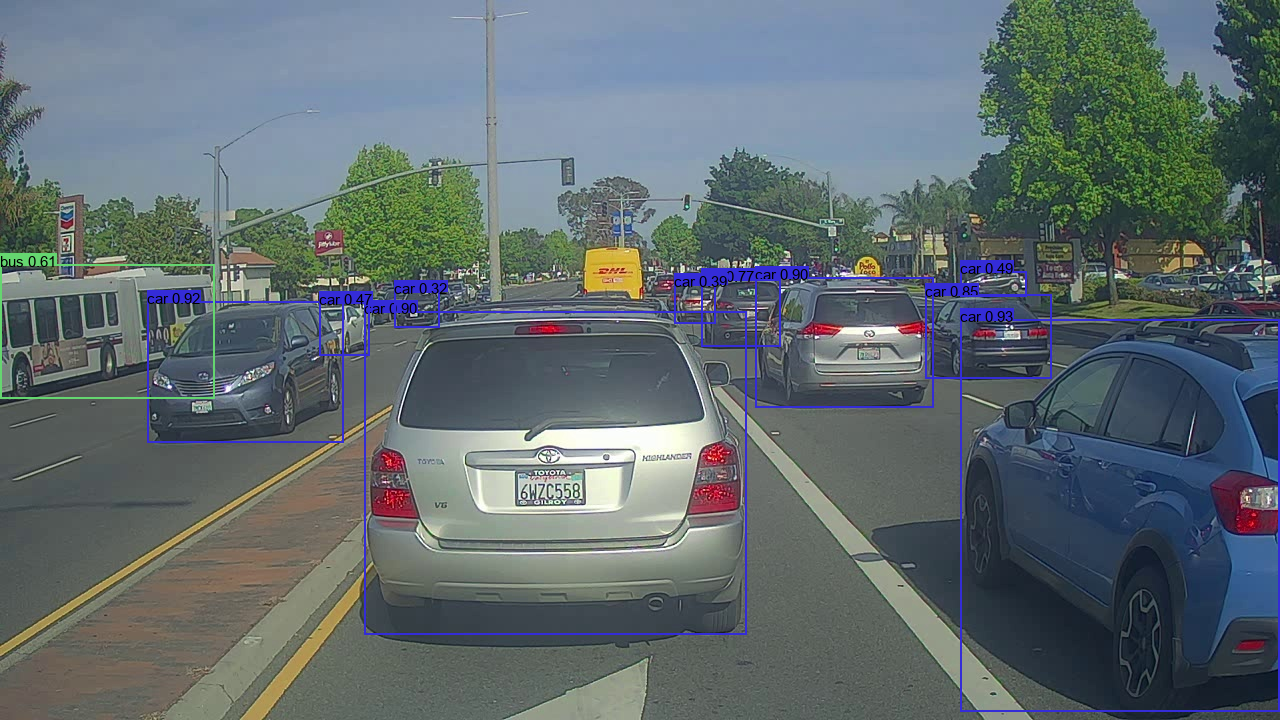


✓ 测试完成！


In [11]:
# ==============================
# 测试预测函数
# ==============================
print("=" * 60)
print("测试预测函数")
print("=" * 60)

# 调用 predict 函数，输入测试图像 test.jpg
# 返回值：
#   out_scores  - 每个检测框的置信度分数 (numpy 数组)
#   out_boxes   - 每个检测框的坐标 [y1, x1, y2, x2] (numpy 数组)
#   out_classes - 每个检测框对应的类别索引 (numpy 数组)
out_scores, out_boxes, out_classes = predict("test.jpg")

# 打印分隔线和提示信息
print("\n" + "=" * 60)
print("✓ 测试完成！")
print("=" * 60)


## 3.8 测试结果统计


In [12]:
def show_detection_stats(scores, boxes, classes, show_details=True):
    """
    显示检测结果统计信息
    
    参数：
        scores : np.ndarray
            每个检测框的置信度分数
        boxes : np.ndarray
            每个检测框的坐标 [y1, x1, y2, x2]
        classes : np.ndarray
            每个检测框对应的类别索引
        show_details : bool, 默认 True
            是否显示每个检测框的详细信息
    """
    # ==========================
    # 如果没有检测到目标
    # ==========================
    if scores is None or len(scores) == 0:
        print("未检测到任何目标")
        return
    
    # 导入 Counter 统计类别数量，导入 numpy 进行统计计算
    from collections import Counter
    
    print("\n" + "=" * 70)
    print("检测结果详细统计")
    print("=" * 70)
    
    # ==========================
    # 1. 类别统计
    # ==========================
    # 将类别索引映射为类别名称，并统计每个类别出现次数
    class_counts = Counter([class_names_list[int(c)] for c in classes])
    
    print(f"\n总共检测到 {len(scores)} 个目标:")
    for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{class_name}: {count} 个")
    
    # ==========================
    # 2. 置信度统计
    # ==========================
    print(f"\n置信度统计:")
    print(f"  最高: {scores.max():.3f}")
    print(f"  最低: {scores.min():.3f}")
    print(f"  平均: {scores.mean():.3f}")
    print(f"  中位数: {np.median(scores):.3f}")
    
    # ==========================
    # 3. 高置信度检测数量（置信度 ≥0.7）
    # ==========================
    high_conf = scores >= 0.7
    print(f"\n高置信度检测 (≥0.7): {high_conf.sum()} 个")
    
    # ==========================
    # 4. 详细列表（可选，显示每个检测框）
    # ==========================
    if show_details:
        print("\n详细列表:")
        for i in range(len(scores)):
            class_name = class_names_list[int(classes[i])]  # 类别名称
            score = scores[i]                               # 置信度
            box = boxes[i]                                  # 边界框坐标
            print(f"  {i+1}. {class_name} {score:.2f} - 位置: {box.astype(int)}")
    
    print("\n" + "=" * 70)


# ==========================
# 调用函数显示检测统计
# ==========================
show_detection_stats(out_scores, out_boxes, out_classes, show_details=True)



检测结果详细统计

总共检测到 11 个目标:
car: 10 个
bus: 1 个

置信度统计:
  最高: 0.925
  最低: 0.321
  平均: 0.687
  中位数: 0.767

高置信度检测 (≥0.7): 6 个

详细列表:
  1. car 0.93 - 位置: [ 319  960  711 1279]
  2. car 0.92 - 位置: [301 147 442 343]
  3. car 0.90 - 位置: [277 755 407 933]
  4. car 0.90 - 位置: [311 364 634 746]
  5. car 0.85 - 位置: [ 294  925  378 1051]
  6. car 0.77 - 位置: [279 701 346 780]
  7. bus 0.61 - 位置: [264   0 398 214]
  8. car 0.49 - 位置: [ 271  960  296 1026]
  9. car 0.47 - 位置: [302 319 355 369]
  10. car 0.39 - 位置: [284 674 323 715]
  11. car 0.32 - 位置: [291 394 327 439]



## 3.9 - 批量处理图像

批量处理是实际应用中的常见需求。与TensorFlow版本相比，PyTorch版本的批量处理有以下特点：

**批量处理的优势**：
1. **自动化处理**：一次性处理多张图像，无需手动逐个运行
2. **性能统计**：记录处理时间、检测数量等统计信息
3. **错误容忍**：单张图像失败不影响其他图像的处理
4. **资源管理**：可以控制是否显示图像以节省内存

**PyTorch vs TensorFlow批量处理的区别**：

**TensorFlow版本**：
```python
# 需要在循环中调用predict()
for image_file in image_files:
    out_scores, out_boxes, out_classes = predict(sess, image_file)
```
- 需要维护TensorFlow Session
- 每次调用需要feed_dict
- 图像预处理需要手动调用preprocess_image()

**PyTorch版本**：
```python
# 更简洁的调用方式
for image_file in image_files:
    scores, boxes, classes = predict(image_file, is_plot=False)
```
- 无需Session，直接调用模型
- 自动预处理和后处理
- 可设置is_plot=False节省内存

**批量处理的最佳实践**：
1. 设置`is_plot=False`避免显示所有图像（节省内存和时间）
2. 设置`is_show_info=True`以监控处理进度
3. 使用try-except捕获错误，避免一个失败导致全部中断
4. 记录统计信息（总数、成功数、失败数、平均耗时等）

**性能优化建议**：
- 如果有GPU，使用`device='cuda'`可以显著加速
- 对于大批量处理，可以考虑使用模型的batch prediction功能
- YOLOv5支持直接传入文件夹路径进行批量处理


In [13]:
# ==============================
# 批量处理图像
# ==============================
import time
from PIL import Image, ImageFile
# 遇到损坏或不完整的图片时，PIL 不会报错直接跳过
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("=" * 70)
print("开始批量处理图像")
print("=" * 70)

# 初始化统计变量
total_detections = 0   # 总共检测到的目标数量
total_time = 0         # 总处理时间（秒）
processed_count = 0    # 成功处理的图片数量
failed_count = 0       # 处理失败的图片数量

# 假设批量处理 images 文件夹下的 0001.jpg ~ 0120.jpg
for i in range(1, 121):
    # 文件名固定 4 位数字，如 0001.jpg, 0002.jpg
    filename = str(i).zfill(4) + ".jpg"
    img_path = os.path.join("images", filename)  # 拼接完整路径
    
    # 如果图片不存在，跳过
    if not os.path.exists(img_path):
        continue

    print(f"\n处理 {filename}...")

    try:
        # 记录开始时间
        start_time = time.time()
        
        # 调用预测函数
        scores, boxes, classes = predict(
            filename,          # 图片文件名
            is_show_info=True, # 显示每张图片的处理信息
            is_plot=False      # 不显示图像，节省时间
        )
        
        # 计算耗时
        elapsed = time.time() - start_time
        total_time += elapsed

        # 更新总检测数量
        if scores is not None and len(scores) > 0:
            total_detections += len(scores)
        
        # 更新成功处理数量
        processed_count += 1
        print(f"  耗时: {elapsed:.2f} 秒")

    except Exception as e:
        # 捕获异常，记录失败数量
        print(f"处理失败: {e}")
        failed_count += 1


开始批量处理图像

处理 0001.jpg...
正在处理图像: 0001.jpg (尺寸: (1280, 720))
在 0001.jpg 中找到了 8 个锚框。
fire hydrant 0.56 (19, 383) -> (43, 434)
car 0.49 (544, 294) -> (563, 314)
car 0.46 (565, 292) -> (626, 315)
car 0.39 (135, 308) -> (193, 336)
car 0.29 (616, 298) -> (640, 313)
car 0.29 (278, 306) -> (343, 338)
car 0.26 (338, 306) -> (386, 327)
car 0.25 (318, 310) -> (343, 336)
结果已保存到: out\0001.jpg
  耗时: 0.13 秒

处理 0002.jpg...
正在处理图像: 0002.jpg (尺寸: (1280, 720))
在 0002.jpg 中找到了 12 个锚框。
car 0.76 (309, 302) -> (393, 337)
car 0.72 (1217, 488) -> (1279, 716)
car 0.65 (495, 288) -> (582, 316)
car 0.65 (388, 291) -> (459, 315)
traffic light 0.51 (1140, 1) -> (1279, 230)
car 0.48 (247, 293) -> (310, 322)
car 0.46 (757, 279) -> (803, 303)
fire hydrant 0.38 (877, 343) -> (891, 378)
person 0.32 (686, 305) -> (699, 330)
traffic light 0.30 (416, 153) -> (431, 186)
traffic light 0.27 (657, 202) -> (667, 219)
car 0.27 (815, 284) -> (844, 305)
结果已保存到: out\0002.jpg
  耗时: 0.14 秒

处理 0003.jpg...
正在处理图像: 0003.jpg (尺寸: (1280

## 3.10 查看批量处理的某张图


显示检测结果: 0002.jpg


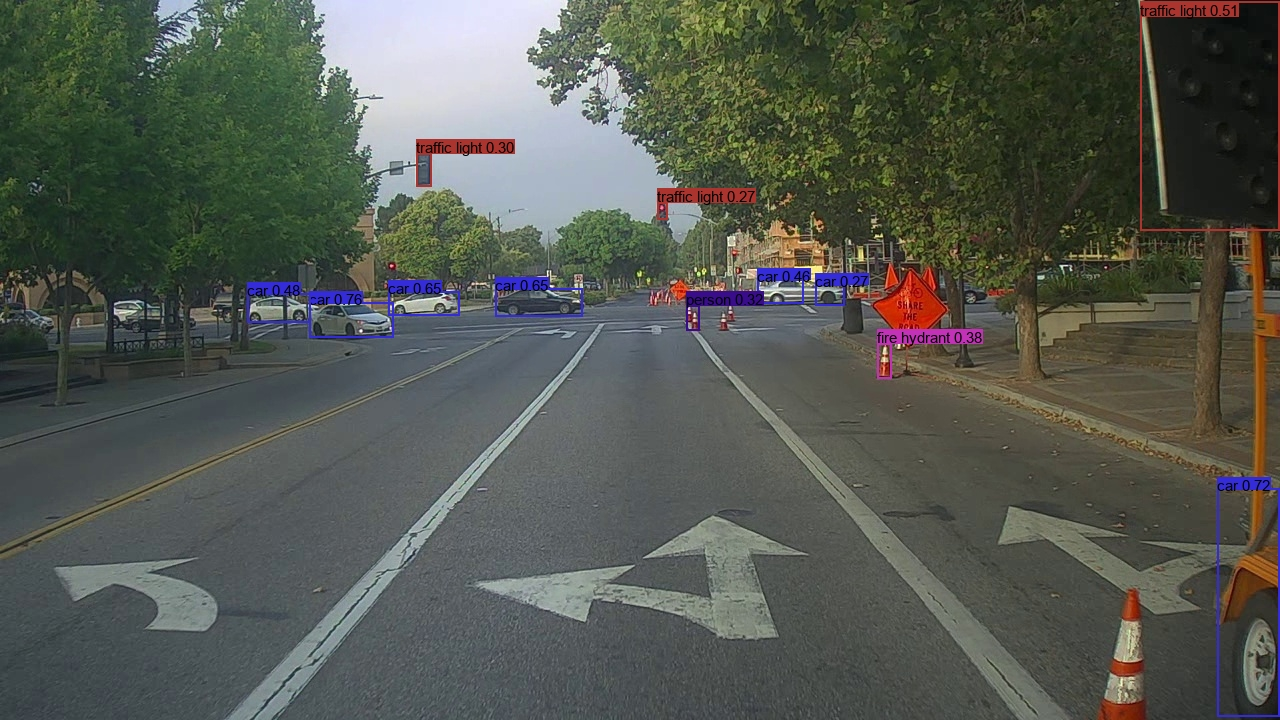

In [14]:
# ==============================
# 查看批量处理后的某张图片
# ==============================
from IPython.display import Image as IPImage

# 可以修改这里的文件名来查看不同图片的处理结果
image_to_view = "0002.jpg"  # 示例：0001.jpg, 0002.jpg, ...

# 拼接输出路径（批量处理时保存的路径）
output_path = f"out/{image_to_view}"

# 判断文件是否存在
if os.path.exists(output_path):
    print(f"显示检测结果: {image_to_view}")
    display(IPImage(filename=output_path))  # 使用 IPython.display 显示图像
else:
    print(f"文件不存在: {output_path}")
    print("请先运行批量处理代码")


### 🎯 完美！现在你可以：

### ✅ 已经成功的功能：

1. **单张图像检测** - 使用 `predict("test.jpg")`
2. **批量图像处理** - 运行上面的批量处理代码
3. **查看结果** - 使用 `IPython.display` 显示保存的图片

### 📝 使用技巧：

```python
# 检测并显示图片
out_scores, out_boxes, out_classes = predict("test.jpg", is_plot=True)

# 只检测不显示（批量处理时）
out_scores, out_boxes, out_classes = predict("test.jpg", is_plot=False)

# 调整阈值
out_scores, out_boxes, out_classes = predict("test.jpg", conf_threshold=0.3, iou_threshold=0.5)
```

### 🎉 恭喜完成PyTorch版YOLO车辆检测！


## 4- 扩展功能

除了基本的图像检测，PyTorch版的YOLOv5还提供了许多强大的扩展功能。这些功能在TensorFlow版本中需要大量额外的编码工作，但在PyTorch/YOLOv5中只需简单调用即可实现。

### 4.1 - 视频检测

YOLOv5原生支持视频检测，这是相对于TensorFlow版本的一个重大优势。

**TensorFlow版本实现视频检测的复杂步骤**：
```python
# TensorFlow版本需要手动处理每一帧
import cv2

video = cv2.VideoCapture("video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    
    # 保存帧为临时图像
    cv2.imwrite('temp_frame.jpg', frame)
    
    # 调用predict函数
    out_scores, out_boxes, out_classes = predict(sess, 'temp_frame.jpg')
    
    # 读取处理后的图像
    processed = cv2.imread('out/temp_frame.jpg')
    out.write(processed)

video.release()
out.release()
```
需要处理：帧读取、编码器设置、帧率匹配、临时文件管理等

**PyTorch/YOLOv5版本（一行代码）**：
```python
# 一行代码完成整个视频检测！
results = yolo_model.predict(source="video.mp4", save=True)
```

**视频检测的主要特点**：
- ✅ **自动处理**：自动读取视频、处理每一帧、写入结果视频
- ✅ **实时显示**：可以选择实时显示检测过程（`show=True`）
- ✅ **多种格式支持**：支持mp4、avi、mov、mkv等常见视频格式
- ✅ **流式输入**：支持视频文件、RTSP流、HTTP流等
- ✅ **高效处理**：利用GPU加速，可以达到实时或超实时处理速度
- ✅ **批量处理**：可以同时处理多个视频文件

**应用场景**：
- 📹 监控视频分析和异常检测
- 🚗 自动驾驶场景记录分析
- ⚽ 体育赛事分析和精彩回放
- 🚶 人流统计和行为分析
- 🏭 工业质检视频分析

下面是一个封装好的视频检测函数：


In [15]:
# ==============================
# 视频目标检测（流式模式）
# ==============================
def predict_video(video_path, output_path="output_video.mp4", conf_threshold=0.25, iou_threshold=0.45):
    """
    对视频进行目标检测（流式模式，避免内存爆炸）
    
    参数：
        video_path : str
            输入视频路径
        output_path : str
            输出视频路径（YOLO 默认保存到 runs 下）
        conf_threshold : float
            置信度阈值，小于该值的框会被丢弃
        iou_threshold : float
            NMS 的 IoU 阈值
    """
    import os
    os.makedirs("runs", exist_ok=True)  # 确保输出目录存在
    
    # ------------------------------
    # 流式处理视频，逐帧预测，避免占用过多内存
    # ------------------------------
    results = yolo_model.predict(
        source=video_path,    # 输入视频路径
        conf=conf_threshold,  # 置信度阈值
        iou=iou_threshold,    # NMS 阈值
        device=device,        # 计算设备
        save=True,            # 保存结果视频
        stream=True           # 流式处理，每次只处理一帧
    )
    
    # 遍历每一帧结果，如果需要可以提取检测框信息
    for frame_idx, r in enumerate(results):
        # r.boxes -> 检测框对象
        # r.masks -> 分割掩码（如果有）
        # r.probs -> 分类概率（如果有）
        # 可以在这里添加自定义处理逻辑，例如统计每帧检测数量
        print(f"帧 {frame_idx+1} 检测到 {len(r.boxes)} 个目标")
#        sys.stdout.flush()
    
    print(f"\n✅ 视频处理完成！结果保存在 runs文件夹中")


In [16]:
predict_video("test_video.mp4", conf_threshold=0.3)

帧 1 检测到 5 个目标
帧 2 检测到 5 个目标
帧 3 检测到 5 个目标
帧 4 检测到 5 个目标
帧 5 检测到 5 个目标
帧 6 检测到 5 个目标
帧 7 检测到 5 个目标
帧 8 检测到 5 个目标
帧 9 检测到 5 个目标
帧 10 检测到 5 个目标
帧 11 检测到 5 个目标
帧 12 检测到 5 个目标
帧 13 检测到 5 个目标
帧 14 检测到 5 个目标
帧 15 检测到 5 个目标
帧 16 检测到 5 个目标
帧 17 检测到 5 个目标
帧 18 检测到 5 个目标
帧 19 检测到 5 个目标
帧 20 检测到 5 个目标
帧 21 检测到 5 个目标
帧 22 检测到 5 个目标
帧 23 检测到 5 个目标
帧 24 检测到 5 个目标
帧 25 检测到 5 个目标
帧 26 检测到 5 个目标
帧 27 检测到 5 个目标
帧 28 检测到 5 个目标
帧 29 检测到 5 个目标
帧 30 检测到 5 个目标
帧 31 检测到 5 个目标
帧 32 检测到 5 个目标
帧 33 检测到 5 个目标
帧 34 检测到 5 个目标
帧 35 检测到 5 个目标
帧 36 检测到 5 个目标
帧 37 检测到 5 个目标
帧 38 检测到 5 个目标
帧 39 检测到 5 个目标
帧 40 检测到 5 个目标
帧 41 检测到 5 个目标
帧 42 检测到 5 个目标
帧 43 检测到 5 个目标
帧 44 检测到 5 个目标
帧 45 检测到 5 个目标
帧 46 检测到 9 个目标
帧 47 检测到 9 个目标
帧 48 检测到 10 个目标
帧 49 检测到 10 个目标
帧 50 检测到 10 个目标
帧 51 检测到 10 个目标
帧 52 检测到 10 个目标
帧 53 检测到 10 个目标
帧 54 检测到 10 个目标
帧 55 检测到 7 个目标
帧 56 检测到 7 个目标
帧 57 检测到 7 个目标
帧 58 检测到 7 个目标
帧 59 检测到 7 个目标
帧 60 检测到 7 个目标
帧 61 检测到 7 个目标
帧 62 检测到 7 个目标
帧 63 检测到 7 个目标
帧 64 检测到 7 个目标
帧 65 检测到 12 个目标
帧 66 检测到 12 个目标
帧 67 检测到 1

### 4.2 - 实时摄像头检测

YOLOv5还支持实时摄像头检测，这对于开发实时应用非常有用。

**TensorFlow版本实现实时检测的挑战**：
- 需要使用OpenCV捕获摄像头帧
- 需要实时调用predict()函数
- 需要处理显示窗口和键盘中断
- 需要手动管理帧率以避免延迟
- Session管理在循环中可能导致内存问题

**PyTorch/YOLOv5版本的优势**：
```python
# 一行代码启动实时检测！
results = yolo_model.predict(source=0, show=True)
```

**实时检测的主要特点**：
- ⚡ **零延迟启动**：直接调用即可开始检测
- 🎥 **多摄像头支持**：source=0（默认摄像头）、source=1（第二个摄像头）等
- 🖥️ **实时显示**：自动打开检测结果窗口
- ⌨️ **便捷退出**：按'q'键退出
- 📊 **FPS显示**：自动显示当前帧率
- 🔄 **自动调优**：根据硬件性能自动调整处理速度

**应用场景**：
- 🔒 实时安防监控系统
- 🏬 零售店客流分析
- 🚦 交通流量监测
- 🤖 机器人视觉导航
- 👤 人脸检测和识别系统

**与视频检测的区别**：
| 特性 | 摄像头检测 | 视频文件检测 |
|------|-----------|-------------|
| 输入源 | 实时摄像头流 | 预录制视频文件 |
| 处理模式 | 实时 | 离线 |
| 保存结果 | 可选 | 通常保存 |
| 帧率要求 | 尽可能高（实时性） | 与原视频一致 |
| 典型用途 | 监控、演示 | 分析、记录 |

下面是一个封装好的摄像头检测函数示例：


In [63]:
# ==============================
# 实时摄像头目标检测（示例）
# ==============================
def predict_webcam(conf_threshold=0.25, iou_threshold=0.45):
    """
    使用摄像头进行实时目标检测
    
    参数：
        conf_threshold : float
            置信度阈值，小于该值的框会被丢弃
        iou_threshold : float
            NMS 的 IoU 阈值
    """
    # -----------------------------
    # 使用 YOLOv5 的内置实时检测功能
    # -----------------------------
    # source=0 表示使用系统默认摄像头
    results = yolo_model.predict(
        source=0,            # 摄像头索引
        conf=conf_threshold, # 置信度阈值
        iou=iou_threshold,   # NMS 阈值
        show=True,           # 实时显示图像
        device=device        # 指定计算设备（CPU/GPU）
    )
    
    print("✅ 摄像头检测已启动，按 'q' 键退出")

# -----------------------------
# 使用示例（取消注释运行）
# -----------------------------
# predict_webcam()


如果你将YOLO放在循环中对所有图像运行，结果大概如下：

<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center>YOLO 模型对从硅谷路上摄像头拍摄的图像进行预测的结果 <br> 感谢 [drive.ai](https://www.drive.ai/) 提供数据集！</center></caption>


## 5 - 总结与思考

### 5.1 - 本练习的核心学习要点

**目标检测算法理解**：
1. **YOLO的工作原理**：理解"看一次"就完成检测的核心思想
2. **IoU（交并比）**：掌握如何衡量边界框重叠程度，这是NMS的基础
3. **NMS（非极大值抑制）**：理解如何去除重复检测，保留最佳结果
4. **置信度过滤**：学会如何通过阈值控制检测的精度和召回率
5. **边界框处理**：理解不同坐标表示方式的转换

**PyTorch深度学习框架**：
1. **PyTorch基础**：掌握tensor操作、模型加载、GPU使用等基本概念
2. **模型推理**：了解如何使用预训练模型进行推理（`model.predict()`）
3. **设备管理**：理解CPU/GPU设备的选择和使用
4. **批处理技巧**：学会高效处理多张图像
5. **错误处理**：掌握异常处理和调试技巧

**实际应用技能**：
1. **图像检测**：能够在单张或批量图像上运行目标检测
2. **视频处理**：了解如何将检测扩展到视频和实时流
3. **结果可视化**：掌握如何绘制和保存检测结果
4. **参数调优**：学会调整置信度和IoU阈值以适应不同场景
5. **问题诊断**：能够排查和解决常见问题（如内核崩溃、内存不足等）

**YOLO工作流程**

1. **图像预处理**：调整到模型要求的尺寸（如640x640）
2. **模型推理**：通过深度神经网络提取特征并预测
3. **解码输出**：将网络输出转换为边界框、置信度和类别
4. **置信度过滤**：去除低置信度的检测框
5. **非极大值抑制**：去除重复的检测框
6. **坐标映射**：将边界框坐标映射回原始图像尺寸
7. **结果可视化**：在图像上绘制检测结果

**关键参数**

 - `conf_threshold`（置信度阈值）：控制检测的敏感度，值越高越严格
   - 推荐值：0.25-0.5
   - 值太低：会产生很多误检
   - 值太高：可能漏检一些目标
   
 - `iou_threshold`（IoU阈值）：控制NMS的强度，值越低去重越激进
   - 推荐值：0.45-0.5
   - 值太低：可能去除正确的检测框
   - 值太高：可能保留重复的检测框

### 5.2 - PyTorch vs TensorFlow版本的关键差异总结

| 方面 | TensorFlow/Keras版本 | PyTorch/YOLOv5版本 | 优势方 |
|------|---------------------|-------------------|--------|
| **代码复杂度** | 需要实现多个辅助函数 | 直接调用高层API | PyTorch ✅ |
| **Session管理** | 需要创建和管理sess | 无需Session | PyTorch ✅ |
| **预处理** | 手动调用preprocess_image | 自动处理 | PyTorch ✅ |
| **后处理** | 手动实现NMS等 | 自动完成 | PyTorch ✅ |
| **视频检测** | 需要大量额外代码 | 一行代码实现 | PyTorch ✅ |
| **GPU加速** | 支持但配置复杂 | 自动识别和使用 | PyTorch ✅ |
| **学习曲线** | 相对陡峭 | 更平缓 | PyTorch ✅ |
| **教学价值** | 深入理解底层细节 | 聚焦算法原理 | 各有千秋 |

### 5.3 - 进一步探索建议

**初级探索**：
1. ✨ 尝试不同的YOLOv5模型（yolov5n/s/m/l/x），比较速度和精度的权衡
2. 🎛️ 调整`conf_threshold`和`iou_threshold`，观察对检测结果的影响
3. 📸 在更多不同场景的图像上测试模型（室内、夜间、雨天等）
4. 📊 统计分析检测结果（如每张图平均检测多少目标）
5. 🎨 自定义边界框的颜色和样式

**中级探索**：
1. 🎬 实现视频批量处理和结果统计
2. 📹 尝试实时摄像头检测并优化帧率
3. 🔍 学习如何在特定类别上进行检测（如只检测汽车）
4. 💾 实现检测结果的JSON/CSV导出
5. 🖼️ 制作检测结果的对比图和统计图表

**高级探索**：
1. 🎓 在自己标注的数据集上微调YOLOv5模型（transfer learning）
2. 🚀 探索YOLOv8、YOLO-NAS等更新的架构
3. ⚙️ 学习如何将模型导出为ONNX格式以便部署
4. 🌐 将检测模型部署为Web API服务
5. 📱 探索移动端部署（TensorFlow Lite、ONNX Mobile等）
6. 🏭 了解工业应用中的性能优化技巧（量化、剪枝等）

### 5.4 - 学习资源推荐

**官方文档**：
- 📚 [Ultralytics YOLOv5 官方文档](https://docs.ultralytics.com/yolov5/)
- 🔥 [PyTorch 官方教程](https://pytorch.org/tutorials/)
- 📖 [YOLOv5 GitHub仓库](https://github.com/ultralytics/yolov5)

**学术论文**：
- 📄 [YOLOv1 论文](https://arxiv.org/abs/1506.02640) - Redmon et al., 2016
- 📄 [YOLOv2 论文](https://arxiv.org/abs/1612.08242) - Redmon & Farhadi, 2016
- 📄 [YOLOv3 论文](https://arxiv.org/abs/1804.02767) - Redmon & Farhadi, 2018

**实践项目**：
- 💡 尝试在GitHub上找开源的YOLO项目学习
- 🎯 参加Kaggle上的目标检测竞赛
- 🤝 加入计算机视觉相关的社区和论坛

### 🎉 恭喜你完成PyTorch版YOLO目标检测练习！

你已经掌握了：
- ✅ 现代目标检测算法的核心原理
- ✅ PyTorch深度学习框架的实际应用
- ✅ 从图像到视频的完整检测流程
- ✅ 实际项目中的调试和优化技巧

**下一步，你可以**：
- 🚗 将这个技术应用到自己感兴趣的项目中
- 📚 深入学习更高级的目标检测算法
- 🌟 探索计算机视觉的其他领域（分割、跟踪、3D检测等）
- 🎓 考虑在实际项目或研究中应用所学知识

**祝你在计算机视觉和深度学习的道路上越走越远！** 🚀🎯✨
